In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
from IPython import display
import time
from tqdm.notebook import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
env = gym.make('LunarLander-v2', render_mode="rgb_array")

In [2]:
class Actor(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(8, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 4)
        )
    
    def forward(self, state):
        state = torch.tensor(state).to(device)
        return self.main(state)

class Critic(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(8, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )
    
    def forward(self, state):
        state = torch.tensor(state).to(device)
        return self.main(state)

In [3]:
actor = Actor().to(device)
actor_optim = torch.optim.SGD(actor.parameters(), lr=1e-3)
critic = Critic().to(device)
critic_optim = torch.optim.SGD(critic.parameters(), lr=1e-3)
cross_entropy = nn.CrossEntropyLoss()
mse = nn.MSELoss()
N_EPISODES = 5
EPOCHS = 500
DISCOUNT_FACTOR = 0.9

In [7]:
def collect_training_data():
    gains = []
    rewards = []
    losses = []
    values = []
    As = []
    total_reward = 0
    final_reward = 0
    for _ in range(N_EPISODES):
        temp_rewards, temp_gains, temp_values = [], [], []
        state, info = env.reset()
        terminated = truncated = False
        while not (terminated or truncated):
            action_prob = actor(state)
            value = critic(state)
            action = torch.multinomial(F.softmax(action_prob, dim=-1), num_samples=1).squeeze()
            state, reward, terminated, truncated, info = env.step(action.item())
            losses.append(cross_entropy(action_prob, action))
            temp_rewards.append(reward)
            temp_values.append(value)
            total_reward += reward
        final_reward += reward
        env.close()

        for i in range(len(temp_rewards)):
            gain = 0
            for j in range(i, len(temp_rewards)):
                gain += temp_rewards[j]*(DISCOUNT_FACTOR**(j-i))
            temp_gains.append(gain)
        
        for i in range(len(temp_rewards)):
            if i == (len(temp_rewards)-1):
                As.append(temp_rewards[i] - temp_values[i])
            else:
                As.append(temp_rewards[i] + temp_values[i+1] - temp_values[i])

        rewards.extend(temp_rewards)
        gains.extend(temp_gains)
        values.extend(temp_values)
    
    actor_loss = 0
    for i in range(len(losses)):
        actor_loss += losses[i]*As[i]
    
    values = torch.cat(values).to(device)
    gains = torch.tensor(gains).to(device).float()
    critic_loss = mse(values, gains)
    return actor_loss, critic_loss, total_reward/N_EPISODES, final_reward/N_EPISODES

In [8]:
def training_loop():
    actor.train()
    critic.train()
    actor_optim.zero_grad()
    critic_optim.zero_grad()
    actor_loss, critic_loss, total_reward, final_reward = collect_training_data()
    actor_loss.backward(retain_graph=True)
    critic_loss.backward()
    actor_optim.step()
    critic_optim.step()
    return total_reward, final_reward

In [9]:
total_rewards, final_rewards, times = [], [], []
for i in range(EPOCHS):
   time1 = time.time()
   total_reward, final_reward = training_loop()
   total_rewards.append(total_reward)
   final_rewards.append(final_reward)
   time2 = time.time()
   times.append(time2-time1)
   print(f'Epoch{i+1}, total reward:{total_reward}, final reward:{final_reward}, time:{round(time2-time1, 2)}')

Epoch1, total reward:-209.6073693055533, final reward:-100.0, time:0.28
Epoch2, total reward:-160.58707215805617, final reward:-100.0, time:0.25
Epoch3, total reward:-304.87329509884637, final reward:-100.0, time:0.37
Epoch4, total reward:-228.8222179883904, final reward:-100.0, time:0.28
Epoch5, total reward:-190.6433178304294, final reward:-100.0, time:0.27
Epoch6, total reward:-287.06417831660343, final reward:-100.0, time:0.29
Epoch7, total reward:-112.70787369540088, final reward:-100.0, time:0.25
Epoch8, total reward:-208.27548233191663, final reward:-100.0, time:0.28
Epoch9, total reward:-138.0503081120841, final reward:-100.0, time:0.37
Epoch10, total reward:-159.23405247486988, final reward:-100.0, time:0.37
Epoch11, total reward:-136.5941134289059, final reward:-100.0, time:0.31
Epoch12, total reward:-207.0450534543068, final reward:-100.0, time:0.66
Epoch13, total reward:-124.15222609601203, final reward:-100.0, time:0.35
Epoch14, total reward:-227.8608034523698, final rewar

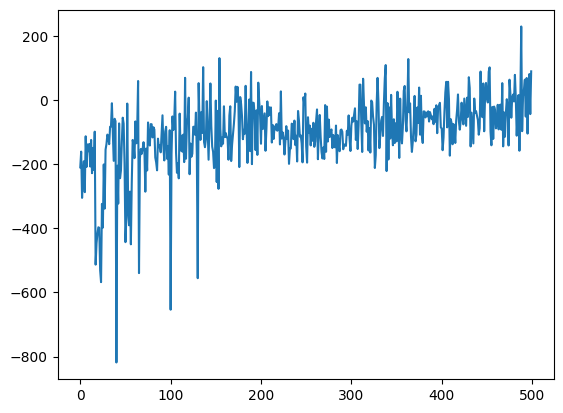

In [10]:
plt.plot(total_rewards)

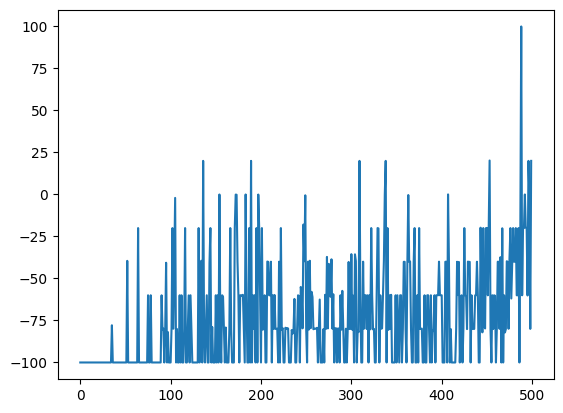

In [11]:
plt.plot(final_rewards)

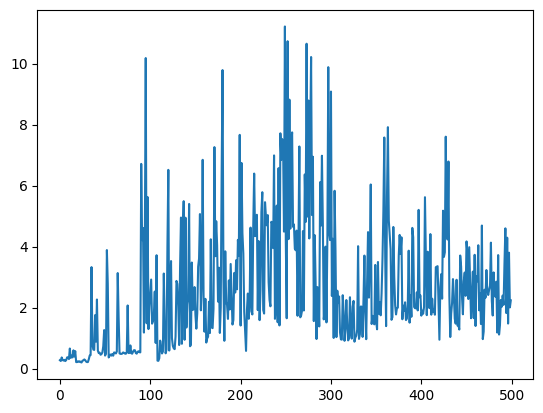

In [12]:
plt.plot(times)

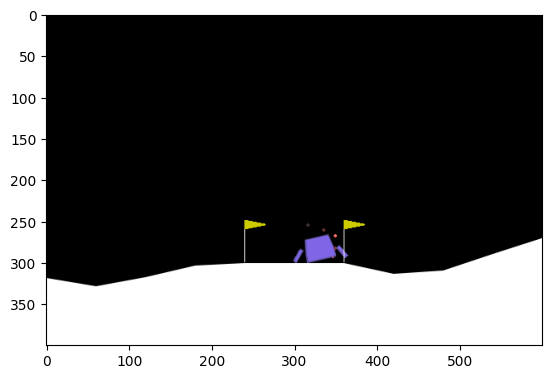

In [13]:
actor.eval()
observation, info = env.reset()
img = plt.imshow(env.render())
terminated = truncated = False
total_reward = 0
while not (terminated or truncated):
    action_prob = actor(observation)
    action = torch.multinomial(F.softmax(action_prob, dim=-1), num_samples=1)
    observation, reward, terminated, truncated, info = env.step(action.item())
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    total_reward += reward
final_reward = reward
env.close()

In [14]:
print(total_reward, final_reward)

-30.260365245028055 -100
